# Data Prepation 

In this notebook, the primary focus is on conducting the necessary data preparation steps to ensure the dataset is ready for future analysis. Additionally, a simple exploratory data analysis (EDA) method is implemented to facilitate the initial data cleaning steps. This EDA provides a preliminary understanding of the dataset, identifies any data quality issues, missing values, outliers, or other anomalies that may need to be addressed.

The initial preprocessing step involves merging 12 data tables that were collected from two subreddits, namely "Investing" and "Personal Finance," over a span of 6 days. By merging these tables, the data can be consolidated for further analysis.

Following the merging process, several data cleaning techniques and visualization methods will be applied to gain insights and ensure data quality. This step aims to identify and/or address any inconsistencies, missing values, or outliers present in the dataset.

Lastly, the dataset will be split into a training set and a test set. This division allows for model training and evaluation on separate subsets of the data, facilitating the assessment of the model's performance and generalization capabilities.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, confusion_matrix

import os

In [2]:
from nlp_functions import clean_data

## Importing and Merge Subreddits Data

In [3]:
def data_importer(directory, data_name_identifier):
    """
    Import data from a specified directory based on a given data name identifier.

    Parameters
    ----------
    directory : str
        The directory path where the data files are located.
    data_name_identifier : str
        The identifier used to filter the data files.

    Returns
    -------
    pandas.DataFrame
        The concatenated data from the identified files, with duplicate rows removed.

    """
    # List all files in the specified directory
    data_lists = os.listdir(directory)

    # Initialize an empty dictionary to store the imported data
    dic = {}

    # Iterate over the files in the directory
    for index, file_name in enumerate(data_lists):
        # Check if the data name identifier is present in the file name
        if data_name_identifier in file_name:
            # Read the CSV file and store it in the dictionary with a unique key
            dic[f"data_{index+1}"] = pd.read_csv(f"../data/{file_name}")

    # Concatenate the data stored in the dictionary and reset the index
    data = pd.concat(dic).reset_index(drop=True)

    # Drop any duplicate rows from the concatenated data
    return data.drop_duplicates()

In [4]:
personalfinance = data_importer(directory='../data', data_name_identifier='-personalfiannce-praw.csv')
personalfinance.head()

,time,title,text,subreddit
0,1.686795e+09,How do I efficiently set aside money for my da...,"So I’m 24(f), and just had my first daughter i...",personalfinance
1,1.686795e+09,I want to sell my new car so I can afford to m...,I currently own a car from 2023 that is 600+ a...,personalfinance
2,1.686794e+09,Disputing a Medical Bill,I am a healthy individual (27f) who was having...,personalfinance
3,1.686794e+09,Using Flat Payment instead of Minimum Balance ...,I'll organize this in a way you can skip parts...,personalfinance
4,1.686794e+09,Best credit card for travel,I’m getting married at the end of the year. I...,personalfinance


In [5]:
personalfinance.shape

(7399, 4)

In [6]:
investing = data_importer(directory='../data', data_name_identifier='-investing-praw.csv')
investing.head()

,time,title,text,subreddit
0,1.686793e+09,Should I go higher on VFIAX in my company matc...,I currently add 25% of my money into VFIAX the...,investing
1,1.686793e+09,An education article about earning season,# Navigating the Busy Earnings Seasons: A Comp...,investing
2,1.686789e+09,Any alternative robo brokers similar to M1?,I started with M1 and loved it however my new ...,investing
3,1.686787e+09,Investing help for a 19 yr old,19 just got a job and want to start investing ...,investing
4,1.686786e+09,What’s with the consistent downward pressure o...,Is it the Hindenburg hit piece ? \n\nAre they ...,investing


In [7]:
investing.shape

(4426, 4)

In [8]:
df = pd.concat([personalfinance, investing], axis=0, ignore_index=True)
df.shape

(11825, 4)

In [9]:
df.duplicated().sum()

0

In [10]:
df.dtypes

time         float64
title         object
text          object
subreddit     object
dtype: object

In [11]:
df.isna().sum()

time           0
title          0
text         118
subreddit      0
dtype: int64

In [12]:
df[df['text'].isna()]['subreddit'].value_counts()

investing          78
personalfinance    40
Name: subreddit, dtype: int64

In [13]:
df['text'].replace(np.nan, '', inplace=True)

> Missing values from posts with no content are replaced with an empty string.

# EDA

In [14]:
df['title_len'] = df['title'].apply(len)
df['title_word_count'] = df['title'].apply(lambda x:len(x.split(' ')))

df['text_len'] = df['text'].apply(lambda x:len(str(x)))
df['text_word_count'] = df['text'].apply(lambda x:len(str(x).split(' ')))

In [15]:
df.groupby('subreddit')[['title_len', 'text_len', 'title_word_count', 'text_word_count']].mean()

,title_len,text_len,title_word_count,text_word_count
subreddit,,,,
investing,66.321509,1132.218708,11.443967,180.629010
personalfinance,65.240573,1115.338830,12.178673,204.319908


> The two subreddits have very similar number of characters, however, personal finance text word count is larger than investing subreddit. 

In [16]:
df.sort_values('title_word_count', ascending=False)[:5]

,time,title,text,subreddit,title_len,title_word_count,text_len,text_word_count
1234,1.552054e+09,My daughter had a student loan for $7500. She ...,EDIT: Floundering around kicked up something ...,personalfinance,298,58,345,57
1817,1.570412e+09,I went into Verizon to open a plan and the sal...,So I went into Verizon to open a new plan. Aft...,personalfinance,294,57,887,185
1611,1.507406e+09,My husband's aging parents asked if we'd be wi...,Edit: My husband would quit his job tomorrow t...,personalfinance,285,56,1221,226
1653,1.535382e+09,I made a cash deposit in a bank ATM machine. T...,Update: I cancelled my accounts with this bank...,personalfinance,288,56,417,78
4557,1.569146e+09,Usaa deleted my checking account for no reason...,,personalfinance,289,56,0,1


In [17]:
df.sort_values('title_word_count', ascending=True)[:5]

,time,title,text,subreddit,title_len,title_word_count,text_len,text_word_count
10354,1.440532e+09,unbelieveable,good to see all our gains have been wiped out ...,investing,13,1,233,42
10633,1.586325e+09,michael-burry-slams-virus-lockdown,https://www.bloomberg.com/news/articles/2020-0...,investing,34,1,184,13
10274,1.582492e+09,SPCE,I think SPCE will have earnings that make the ...,investing,4,1,158,30
10253,1.582134e+09,Bitcoin,Not trying to get into a philosophical debate ...,investing,7,1,404,71
10616,1.440410e+09,FUCK!!!!!!!!!!!!!,"OK, THE DOW IS DOWN 400 MOTHER FUCKING POINTS ...",investing,17,1,137,30


In [18]:
df.sort_values('text_word_count', ascending=False)[:5]

,time,title,text,subreddit,title_len,title_word_count,text_len,text_word_count
8254,1.611921e+09,Gamestop Big Picture: The Short Singularity Pt...,*Disclaimer: I am not a financial advisor. Th...,investing,62,11,36036,6401
10431,1.613418e+09,Huge DD on Electric Last Mile Solutions. Only ...,"Hello All, this is my first DD. It is long bu...",investing,66,14,34215,6379
10176,1.655736e+09,Bitcoin is a new form of investment fraud,tl;dr: Bitcoin is a new form of investment fra...,investing,41,8,32914,5120
1279,1.499307e+09,Student Loans - an Insider's Guide to Forgiven...,"This is meant to be a user-friendly, non-jargo...",personalfinance,58,9,25426,4277
8644,1.618503e+09,Jeff Bezos Releases Final Letter To Amazon Sha...,"""In Amazon’s 1997 letter to shareholders, our ...",investing,55,8,23982,3989


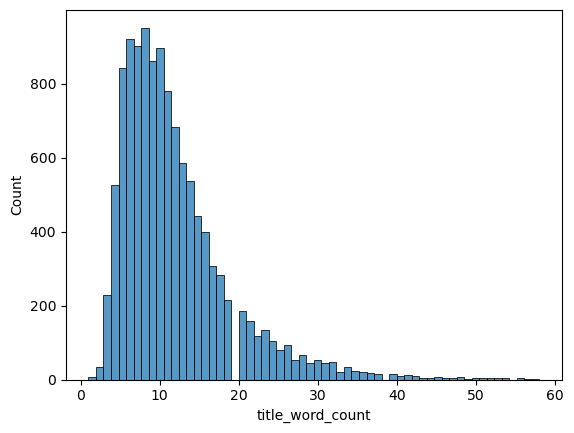

In [19]:
sns.histplot(x=df['title_word_count'], bins=60);

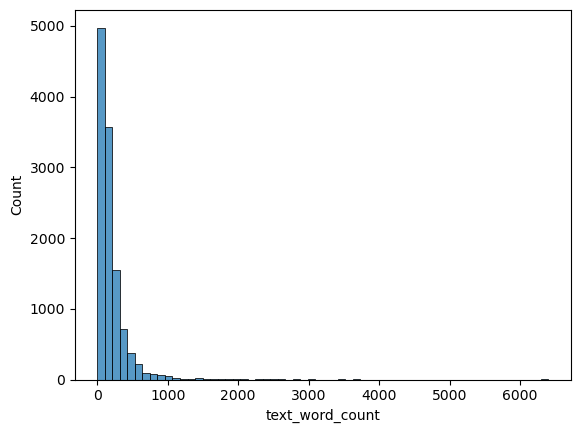

In [20]:
sns.histplot(x=df['text_word_count'], bins=60);

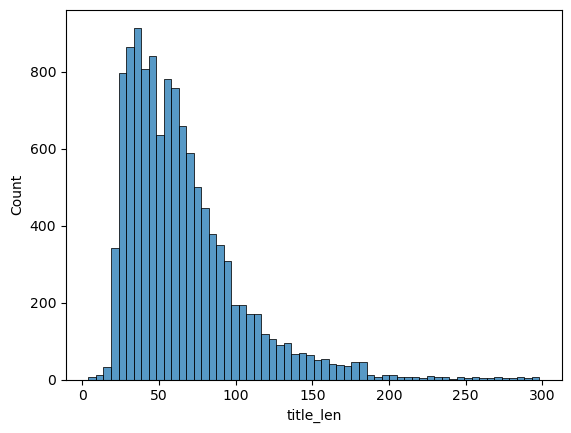

In [21]:
sns.histplot(x=df['title_len'], bins=60);

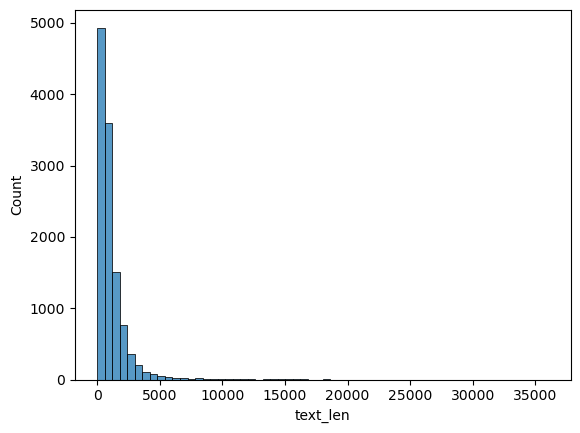

In [22]:
sns.histplot(x=df['text_len'], bins=60);

## Data cleaning

### Merging Text and Title Column
To maximize the information obtained from text analysis, it is beneficial to merge the title and text content of each post together. By combining these two components, we can capture a more comprehensive representation of the post's content for further analysis.

In [23]:
df['full_text'] = df['title'] + ' ' + df['text']

In order to mitigate any potential bias introduced by the subreddit names and to ensure the model is not influenced by them, the titles of both subreddits have been removed from the dataset. This step helps to focus the analysis on the textual content of the posts and avoids any undue influence that may arise from the subreddit names themselves.

In [24]:
df['full_text'].str.lower().str.contains('investing').sum()

1360

In [25]:
df.loc[df['full_text'].str.lower().str.contains('investing'), 'subreddit'].value_counts()

investing          957
personalfinance    403
Name: subreddit, dtype: int64

In [26]:
df['full_text'].str.lower().str.contains('personal finance').sum()

138

In [27]:
df['full_text'] = df['full_text'].str.lower().str.replace('investing', '')
df['full_text'] = df['full_text'].str.lower().str.replace('personal finance', '')

### Getting the data ready for analysis

In [28]:
df['subreddit'] = (df['subreddit']=='personalfinance')*1

In [29]:
df = df[['subreddit', 'full_text']]
df.head()

,subreddit,full_text
0,1,how do i efficiently set aside money for my da...
1,1,i want to sell my new car so i can afford to m...
2,1,disputing a medical bill i am a healthy indivi...
3,1,using flat payment instead of minimum balance ...
4,1,best credit card for travel i’m getting marrie...


## Splitting the Testing Data from the Remaining of the Sample

Before proceeding with the analysis, it is essential to split the data into three subsets: training, validation, and testing. In this case, 20% of the sample will be reserved for the testing data, while the remaining portion will be divided between the training and validation samples. This splitting ensures that we have separate datasets to train the model, tune hyperparameters using the validation set, and evaluate the final performance on the test set, enabling a robust and reliable analysis.

To ensure reproducibility and facilitate future work, it is helpful to create a function that encapsulates all the cleaning steps. This function can be designed to take the raw data as input and return the cleaned data ready for further analysis. By encapsulating the cleaning steps in a single function, it becomes easier to apply the same cleaning process consistently in future projects.

In [30]:
# Importing the data agian!
personalfinance = data_importer(directory='../data', data_name_identifier='-personalfiannce-praw.csv')
investing = data_importer(directory='../data', data_name_identifier='-investing-praw.csv')
df = pd.concat([personalfinance, investing], axis=0, ignore_index=True)

In [31]:
df_test = df.sample(frac=0.2 ,random_state=42)

In [32]:
df_train = df.drop(index=df_test.index)

In [33]:
print('Full sample size:', df.shape)
print('Training sample size:', df_train.shape)
print('Test sample size:', df_test.shape)

Full sample size: (11825, 4)
Training sample size: (9460, 4)
Test sample size: (2365, 4)


Utilizing the clean_data function from the nlp_functions module, we can efficiently clean the training data.

In [34]:
df_train_cleaned = clean_data(df_train)

In [35]:
df_train_cleaned.to_csv('../data/reddit_train.csv', index=False)
df_test.to_csv('../data/reddit_test.csv', index=False)